# Data Science Project Planning

## Data Description

### Player Data

Player data has 196 observations and 7 variables.

Two numerical:

  + played_hours: total hours played by a player
  + Age: age of player

Four character:

  + experience: level of the player ("Beginner", "Amateur", "Regular", "Veteran", "Pro")
  + hashedEmail: anonymized email for privacy.
  + name: player's first name
  + gender: player's gender

One logical:

  + subscribe: whether the player is subscribed to game-related newsletter

Summary stats (See the Exploratory section for computation): 

| |Range|Mean|
|----|----|----|
|Age |[9–58]|21.14|
|Played Hours| [0–223.1]|5.85|


Potential Issues:
* Played hours measurement unclear (self-reported or tracked).
* Wide age range and self-reported experience may introduce bias.
* NA values could skew results.

### Sessions Data

The sessions data has 1535 observations and 5 variables.

Two numerical:

  + original_start_time and original_end_time: session start and end times in UNIX milliseconds.

Three character:

  + start_time and end_time: human-readable versions of the above.
  + hashedEmail links sessions to players.

Summary stats for the numerical timestamps are not meaningful without computing session durations.

Potential Issues:
* Unclear time zones across sessions.
* Missing or inconsistent start/end times.
* Multiple emails per player could fragment data.
* NA values could skew results.

## Questions

Question 2: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

Specific Question: Can player characteristics (experience and age) predict total hours played in the player dataset?
This question addresses our broader question by helping us discover what kinds of players are playing the most (demographically) and assumes that more hours = more sessions = larger contribution of data. 

Wrangling: To prepare for KNN, played_hours will be converted into a factor as Low/Medium/High activity. Experience will be converted to a 1–5 scale, and both predictors will be standardized. Only players.csv will be used, as sessions.csv focuses on timing rather than player traits.

## Exploratory Data Analysis and Visualization

In [37]:
library(tidyverse)
players_url <- "https://raw.githubusercontent.com/averykimura/avery_gamet_project_planning_DSCI100/refs/heads/main/players.csv"
sessions_url <- "https://raw.githubusercontent.com/averykimura/avery_gamet_project_planning_DSCI100/refs/heads/main/sessions.csv"
sessions <- read_csv(sessions_url)
players <- read_csv(players_url)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Wrangling and Summary Stats

In [38]:
players <- rename(players, hashed_email = hashedEmail, age = Age) #variable names are all consistent

players_no_na <- players |> #filtering out na values
  filter(!is.na(age), !is.na(played_hours))

players_summary <- summarise(players, #proper table can be found in Data Description
  age_min = min(age, na.rm=TRUE),
  age_max = max(age, na.rm=TRUE),
  age_mean = mean(age, na.rm=TRUE),
  played_hours_min = min(played_hours, na.rm=TRUE),
  played_hours_max = max(played_hours, na.rm=TRUE),
  played_hours_mean = mean(played_hours, na.rm=TRUE))

players_summary_no_na <- summarise(players_no_na, #we can see the summary stats are not altered by na's.
  age_min = min(age, na.rm=TRUE),
  age_max = max(age, na.rm=TRUE),
  age_mean = mean(age, na.rm=TRUE),
  played_hours_min = min(played_hours, na.rm=TRUE),
  played_hours_max = max(played_hours, na.rm=TRUE),
  played_hours_mean = mean(played_hours, na.rm=TRUE))
                             
players_summary
players_summary_no_na

age_min,age_max,age_mean,played_hours_min,played_hours_max,played_hours_mean
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,58,21.13918,0,223.1,5.845918


age_min,age_max,age_mean,played_hours_min,played_hours_max,played_hours_mean
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,58,21.13918,0,223.1,5.904639


### Plots

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_count()`).”


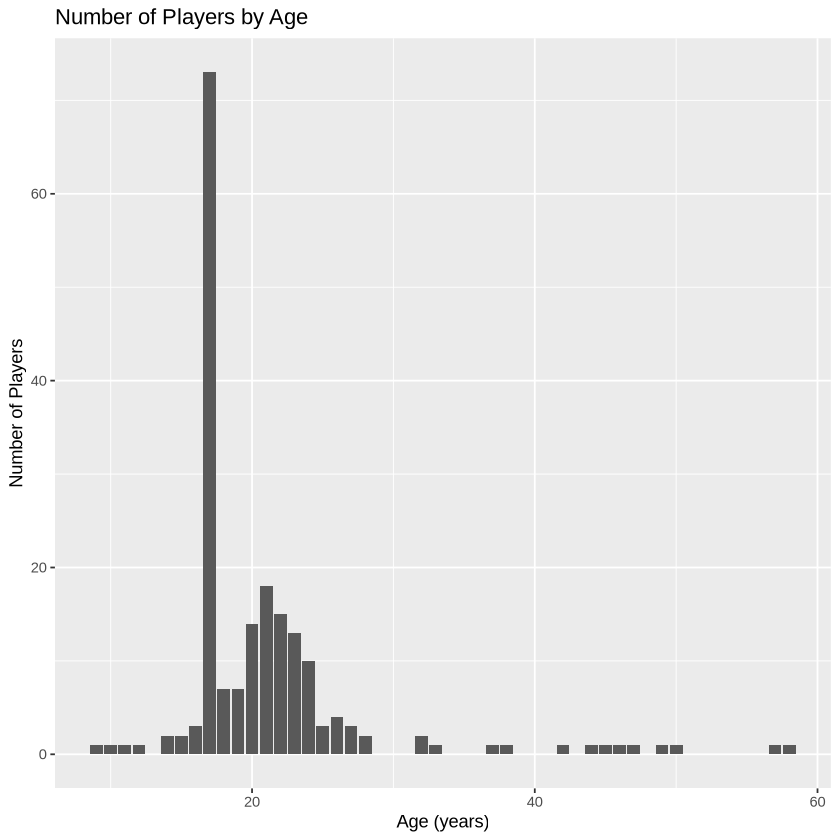

In [39]:
age_plot <- ggplot(players, aes(x = age)) +
  geom_bar() +
  labs(title = "Number of Players by Age", x = "Age (years)", y = "Number of Players")
age_plot

This plot shows that most players are between 15-30 years old, peaking at 16. This concentration is important for identifying which age groups might be most invested/contributing most to played hours. 

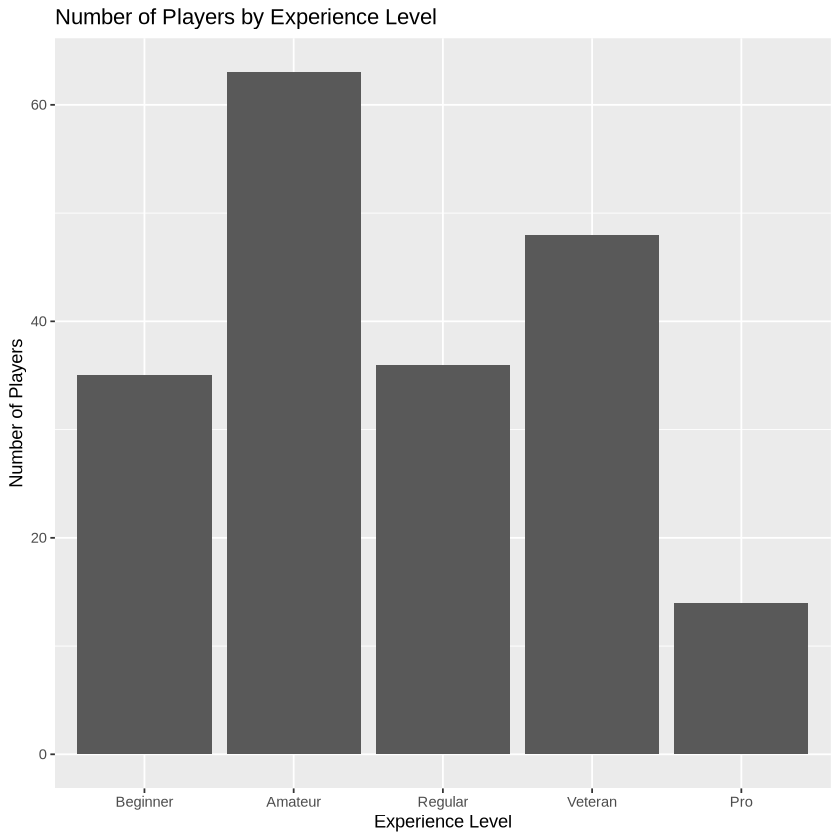

In [34]:
players_exp_order <- players |>
  mutate(experience = factor(experience, 
                             levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro")))

experience_plot <- ggplot(players_exp_order, aes(x = experience)) +
  geom_bar() +
  labs(title = "Number of Players by Experience Level",
    x = "Experience Level",
    y = "Number of Players")
experience_plot

Bars are ordered by presumed skill level. Amateurs are the largest group, while pros are the smallest, which helps identify which demographic contributes most to the data.

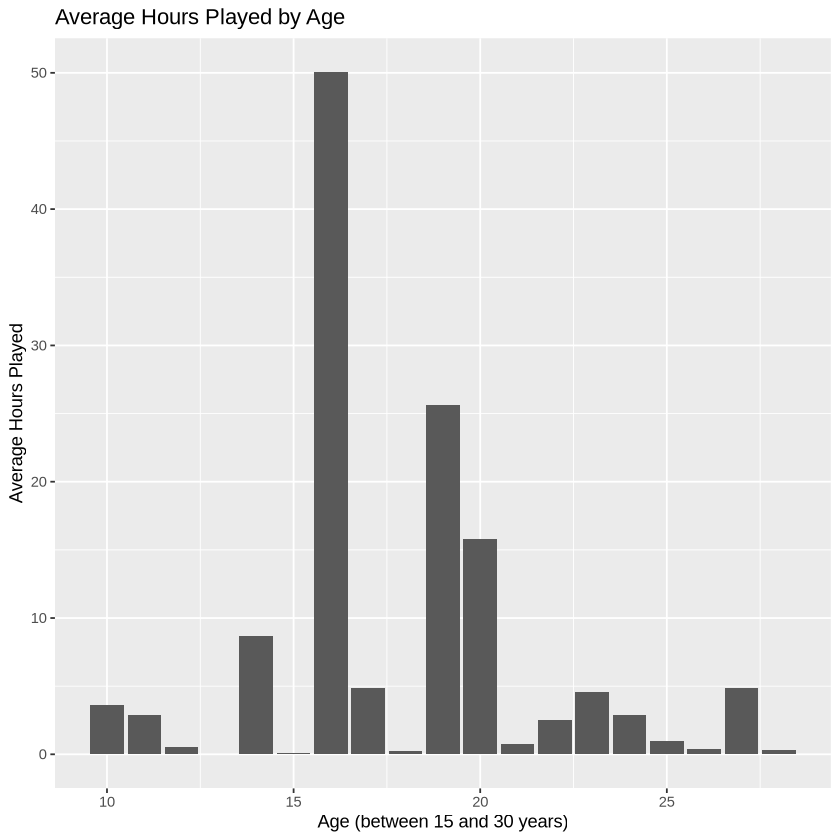

In [35]:
avg_plot <- players |>
  filter(age >= 10, age <= 30) |>
  group_by(age) |>
  summarise(avg_hours = mean(played_hours, na.rm = TRUE)) |>
  ggplot(aes(x = age, y = avg_hours)) +
  geom_bar(stat="identity") +
  labs(title = "Average Hours Played by Age", x = "Age (between 15 and 30 years)", y = "Average Hours Played")

avg_plot

Examining ages 15-30, average play time peaks around age 16, suggesting that teenagers are both the most active and most informative group for predicting player activity.

## Methods and Plan

* I will use K-Nearest Neighbors (KNN) classification to predict a player’s activity level (Low, Medium, High) from age and experience.
* KNN is suitable because it works well with  nonlinear relationships and small sets of numerical predictors.
* It assumes that similar players (once standardized) have similar activity levels.
* It requires that predictors be on comparable scales and that distances reflect similarity.
* Limitations include sensitivity to outliers, class imbalance, and the choice of k.
* The optimal k will be selected using 5-fold cross-validation, with performance evaluated via accuracy and confusion matrices.
* Data will be split 70/30 into training and testing sets, and preprocessing will occur before splitting.

### Github Repository: https://github.com/averykimura/avery_gamet_project_planning_DSCI100.git